In [116]:
import numpy as np
import pandas as pd
import glob
from joblib import Parallel, delayed
from tqdm import tqdm

In [117]:
application = pd.read_csv('./src/application_train.csv')
# application_test = pd.read_csv('./src/application_test.csv')
# application_test doesnt contain target column, it is useless to us because even if we develop a model, we still dont know its accuracy on the training set. 

In [118]:
bureau = pd.read_csv('./src/bureau.csv')

In [119]:
bureau_balance = pd.read_csv('./src/bureau_balance.csv')

In [120]:
credit_card_balance = pd.read_csv('./src/credit_card_balance.csv')

In [121]:
installments_payments = pd.read_csv('./src/installments_payments.csv')

In [122]:
POS_CASH_balance = pd.read_csv('./src/POS_CASH_balance.csv')
previous_application = pd.read_csv('./src/previous_application.csv')

In [123]:
home_credit_columns_description = pd.read_csv('./src/HomeCredit_columns_description.csv', encoding='iso-8859-1',
                                              index_col=0)

In [124]:
# sample_submission = pd.read_csv('./src/sample_submission.csv')

# Data preprocessing

In [125]:
application.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [126]:
# application.loc[:,['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV']]

In [127]:
home_credit_columns_description

,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...
217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


In [128]:
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


the SK_ID_CURR is the unique id for each client

In [129]:
len(application)

307511

In [130]:
len(bureau)

1716428

In [131]:
len(bureau_balance)

27299925

In [132]:
len(credit_card_balance)

3840312

In [133]:
len(installments_payments)

13605401

In [134]:
len(POS_CASH_balance)

10001358

In [135]:
len(previous_application)

1670214

## merge the bureau data with bureau_balance data

In [136]:
status_count = bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].value_counts().unstack().fillna(0)
status_count.columns = ['BUREAU_BALANCE_' + str(col_name) for col_name in status_count.columns]
status_count.reset_index(inplace=True)
month_count = bureau_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].min().abs().rename('BUREAU_BALANCE_MONTH_COUNT')
status_count = status_count.merge(month_count, how='left', on='SK_ID_BUREAU')  # add 0.001 to avoid divide by 0

In [137]:
# scale the status_count by month_count
for col in status_count.columns[1:-1]:
    status_count[col] = status_count[col] / (status_count['BUREAU_BALANCE_MONTH_COUNT'] + 1.001)

In [138]:
status_count.columns

Index(['SK_ID_BUREAU', 'BUREAU_BALANCE_0', 'BUREAU_BALANCE_1',
       'BUREAU_BALANCE_2', 'BUREAU_BALANCE_3', 'BUREAU_BALANCE_4',
       'BUREAU_BALANCE_5', 'BUREAU_BALANCE_C', 'BUREAU_BALANCE_X',
       'BUREAU_BALANCE_MONTH_COUNT'],
      dtype='object')

In [139]:
bureau = bureau.merge(status_count, how='left', on='SK_ID_BUREAU')

In [140]:
bureau.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,...,AMT_ANNUITY,BUREAU_BALANCE_0,BUREAU_BALANCE_1,BUREAU_BALANCE_2,BUREAU_BALANCE_3,BUREAU_BALANCE_4,BUREAU_BALANCE_5,BUREAU_BALANCE_C,BUREAU_BALANCE_X,BUREAU_BALANCE_MONTH_COUNT
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,...,4.896370e+05,774354.000000,774354.000000,774354.000000,774354.000000,774354.000000,774354.000000,774354.000000,774354.000000,774354.000000
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,...,1.571276e+04,0.351976,0.009966,0.000683,0.000236,0.000154,0.001295,0.327617,0.192275,36.288669
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,...,3.258269e+05,0.328245,0.042879,0.007975,0.003747,0.002875,0.024694,0.358784,0.320677,25.449736
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,...,0.000000e+00,0.079545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,...,0.000000e+00,0.239990,0.000000,0.000000,0.000000,0.000000,0.000000,0.160492,0.019607,31.000000
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,...,1.350000e+04,0.580240,0.000000,0.000000,0.000000,0.000000,0.000000,0.692281,0.230751,53.000000
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,...,1.184534e+08,0.999989,0.999923,0.714184,0.399920,0.499875,0.999974,0.999990,0.999990,96.000000


## Cleaning bureau data

In [141]:
# print number of unique item in each column
for col in bureau.columns:
    print(col, 'Unique item:',  len(bureau[col].unique()),'NA:',  len(bureau.loc[bureau[col].isnull()]),'value=0:', len(bureau.loc[bureau[col] == 0]))

SK_ID_CURR Unique item: 305811 NA: 0 value=0: 0
SK_ID_BUREAU Unique item: 1716428 NA: 0 value=0: 0
CREDIT_ACTIVE Unique item: 4 NA: 0 value=0: 0
CREDIT_CURRENCY Unique item: 4 NA: 0 value=0: 0
DAYS_CREDIT Unique item: 2923 NA: 0 value=0: 25
CREDIT_DAY_OVERDUE Unique item: 942 NA: 0 value=0: 1712211
DAYS_CREDIT_ENDDATE Unique item: 14097 NA: 105553 value=0: 883
DAYS_ENDDATE_FACT Unique item: 2918 NA: 633653 value=0: 64
AMT_CREDIT_MAX_OVERDUE Unique item: 68252 NA: 1124488 value=0: 470650
CNT_CREDIT_PROLONG Unique item: 10 NA: 0 value=0: 1707314
AMT_CREDIT_SUM Unique item: 236709 NA: 13 value=0: 66582
AMT_CREDIT_SUM_DEBT Unique item: 226538 NA: 257669 value=0: 1016434
AMT_CREDIT_SUM_LIMIT Unique item: 51727 NA: 591780 value=0: 1050142
AMT_CREDIT_SUM_OVERDUE Unique item: 1616 NA: 0 value=0: 1712270
CREDIT_TYPE Unique item: 15 NA: 0 value=0: 0
DAYS_CREDIT_UPDATE Unique item: 2982 NA: 0 value=0: 605
AMT_ANNUITY Unique item: 40322 NA: 1226791 value=0: 256915
BUREAU_BALANCE_0 Unique item: 463

In [142]:
# def aggregate_do_nothing(bureau, col):
#     res = bureau[col]
#     return res.reindex(application['SK_ID_CURR']).fillna(0).rename('BUREAU_' + col)

In [143]:
def aggregate_count(bureau, col):
    # res = bureau[bureau['SK_ID_CURR'].isin(application['SK_ID_CURR'])]
    # res = res.groupby('SK_ID_CURR')[col].count()
    res = bureau.groupby('SK_ID_CURR')[col].count()
    return res.reindex(application['SK_ID_CURR']).fillna(0).rename('BUREAU_' + col + '_COUNT')

In [144]:
def aggregate_categorical(bureau, col):
    # res = bureau[bureau['SK_ID_CURR'].isin(application['SK_ID_CURR'])]
    # res = res.groupby('SK_ID_CURR')[col].value_counts().unstack()
    res = bureau.groupby('SK_ID_CURR')[col].value_counts().unstack()
    res = res.reindex(application['SK_ID_CURR']).fillna(0)
    res.columns = ['BUREAU_' + col + '_' + str(col_name) for col_name in res.columns]
    return res

In [145]:
def aggregate_avg_max_min_std_skw(bureau, col):
    # res = bureau[bureau['SK_ID_CURR'].isin(application['SK_ID_CURR'])]
    # res = res.groupby('SK_ID_CURR')[col].agg(['mean', 'max', 'min', 'std', 'skew'])
    res = bureau.groupby('SK_ID_CURR')[col].agg(['mean', 'max', 'min', 'std', 'skew'])
    res = res.reindex(application['SK_ID_CURR']).fillna(0)
    res.columns = ['BUREAU_' + col + '_' + col_name for col_name in res.columns]
    return res

In [146]:
def aggregate_avg_max_min_std_skw_nan_count(bureau, col):
    res = bureau[bureau['SK_ID_CURR'].isin(application['SK_ID_CURR'])]
    res = res.groupby('SK_ID_CURR')[col].agg(['mean', 'max', 'min', 'std', 'skew'])
    # count the number of nan
    res['nan_count'] = bureau.groupby('SK_ID_CURR')[col].apply(lambda x: x.isnull().sum())
    res = res.reindex(application['SK_ID_CURR']).fillna(0)
    res.columns = ['BUREAU_' + col + '_' + col_name for col_name in res.columns]
    return res

In [147]:
bureau_agg_dic = {'SK_ID_BUREAU': 'aggregate_count',
                  'CREDIT_ACTIVE': 'aggregate_categorical',
                  'CREDIT_CURRENCY': 'aggregate_categorical',
                  'DAYS_CREDIT': 'aggregate_avg_max_min_std_skw',
                  'CREDIT_DAY_OVERDUE': 'aggregate_avg_max_min_std_skw',
                  'DAYS_CREDIT_ENDDATE': 'aggregate_avg_max_min_std_skw_nan_count',
                  'DAYS_ENDDATE_FACT': 'aggregate_avg_max_min_std_skw_nan_count',
                  'AMT_CREDIT_MAX_OVERDUE': 'aggregate_avg_max_min_std_skw_nan_count',
                  'CNT_CREDIT_PROLONG': 'aggregate_avg_max_min_std_skw',
                  'AMT_CREDIT_SUM': 'aggregate_avg_max_min_std_skw',
                  'AMT_CREDIT_SUM_DEBT': 'aggregate_avg_max_min_std_skw_nan_count',
                  'AMT_CREDIT_SUM_LIMIT': 'aggregate_avg_max_min_std_skw_nan_count',
                  'AMT_CREDIT_SUM_OVERDUE': 'aggregate_avg_max_min_std_skw',
                  'DAYS_CREDIT_UPDATE': 'aggregate_avg_max_min_std_skw',
                  'AMT_ANNUITY': 'aggregate_avg_max_min_std_skw_nan_count',
                  'BUREAU_BALANCE_0': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_1': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_2': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_3': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_4': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_5': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_C': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_X': 'aggregate_avg_max_min_std_skw',
                  'BUREAU_BALANCE_MONTH_COUNT': 'aggregate_avg_max_min_std_skw'}

In [148]:
home_credit_columns_description.where(home_credit_columns_description['Row'] == 'NAME_CONTRACT_STATUS').dropna(axis=0, how='all')['Description'].values[2]

'Contract status (approved, cancelled, ...) of previous application'

In [149]:
# parallel processing
bureau_merging_result = Parallel(n_jobs=-1)(
    delayed(eval(bureau_agg_dic[col]))(bureau[bureau['SK_ID_CURR'].isin(application['SK_ID_CURR'])], col) for col in bureau_agg_dic.keys())# 6min

In [150]:
# merge all the result on SK_ID_CURR
bureau_merging_result = pd.concat(bureau_merging_result, axis=1)

## Cleaning POS Cash data
grace

In [151]:
POS_CASH_balance['NAME_CONTRACT_STATUS'].value_counts()

Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: NAME_CONTRACT_STATUS, dtype: int64

In [152]:
def contract_status(POS_CASH_balance):
    # one hot encode the NAME_CONTRACT_STATUS
    dum = pd.get_dummies(POS_CASH_balance['NAME_CONTRACT_STATUS'])
    for col in dum:
        dum[col] = dum[col] * (1 - POS_CASH_balance['CNT_INSTALMENT_FUTURE'] / POS_CASH_balance['CNT_INSTALMENT'])
    dum.columns = ['POS_CASH_' + str(col_name) for col_name in dum.columns]
    return POS_CASH_balance.loc[:, ['SK_ID_PREV', 'SK_ID_CURR', ]].join(dum).groupby(['SK_ID_CURR', 'SK_ID_PREV']).max().groupby(
        'SK_ID_CURR').mean().reindex(application['SK_ID_CURR']).fillna(0)

In [182]:
def earliest_starting(POS_CASH_balance):
    return POS_CASH_balance.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['MONTHS_BALANCE'].min().abs().groupby(
        'SK_ID_CURR').mean().reindex(application['SK_ID_CURR']).fillna(0).rename('POS_CASH_EARLIEST_STARTING')

def latest_starting(POS_CASH_balance):
    return POS_CASH_balance.groupby(['SK_ID_CURR', 'SK_ID_PREV'])['MONTHS_BALANCE'].max().abs().groupby(
        'SK_ID_CURR').mean().reindex(application['SK_ID_CURR']).fillna(0).rename('POS_CASH_LATEST_STARTING')

In [183]:
contract_status(POS_CASH_balance)

,POS_CASH_Active,POS_CASH_Amortized debt,POS_CASH_Approved,POS_CASH_Canceled,POS_CASH_Completed,POS_CASH_Demand,POS_CASH_Returned to the store,POS_CASH_Signed,POS_CASH_XNA
SK_ID_CURR,,,,,,,,,
100002,0.750000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
100003,0.805556,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0
100004,0.500000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
100006,0.916667,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0
100007,0.826569,0.0,0.0,0.0,0.600000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
456251,0.750000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
456252,0.833333,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
456253,1.000000,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0


In [184]:
earliest_starting(POS_CASH_balance)

SK_ID_CURR
100002    19.000000
100003    43.333333
100004    27.000000
100006    12.000000
100007    42.200000
            ...    
456251     9.000000
456252    82.000000
456253    84.333333
456254    10.000000
456255    22.333333
Name: POS_CASH_EARLIEST_STARTING, Length: 307511, dtype: float64

In [185]:
latest_starting(POS_CASH_balance)

SK_ID_CURR
100002     1.000000
100003    35.000000
100004    24.000000
100006     6.000000
100007    30.000000
            ...    
456251     1.000000
456252    76.000000
456253    79.666667
456254     1.000000
456255    11.500000
Name: POS_CASH_LATEST_STARTING, Length: 307511, dtype: float64

In [186]:
pos_cash_balance_function_list=[contract_status, earliest_starting, latest_starting]
POS_CASH_balance_merging_res=pd.concat([func(POS_CASH_balance) for func in pos_cash_balance_function_list],axis=1)

In [187]:
POS_CASH_balance_merging_res

,POS_CASH_Active,POS_CASH_Amortized debt,POS_CASH_Approved,POS_CASH_Canceled,POS_CASH_Completed,POS_CASH_Demand,POS_CASH_Returned to the store,POS_CASH_Signed,POS_CASH_XNA,POS_CASH_EARLIEST_STARTING,POS_CASH_LATEST_STARTING
SK_ID_CURR,,,,,,,,,,,
100002,0.750000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,19.000000,1.000000
100003,0.805556,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,43.333333,35.000000
100004,0.500000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,27.000000,24.000000
100006,0.916667,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,12.000000,6.000000
100007,0.826569,0.0,0.0,0.0,0.600000,0.0,0.0,0.0,0.0,42.200000,30.000000
...,...,...,...,...,...,...,...,...,...,...,...
456251,0.750000,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,9.000000,1.000000
456252,0.833333,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,82.000000,76.000000
456253,1.000000,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,84.333333,79.666667


## Cleaning Credit card data
evelyn

In [156]:
credit_card_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,...,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,...,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,...,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


## Cleaning Installment data
fu

## Cleaning Previous application data
nicola

# merge data onto application

In [188]:
full_data = application.merge(bureau_merging_result, how='left', on='SK_ID_CURR').merge(POS_CASH_balance_merging_res, how='left', on='SK_ID_CURR')

In [189]:
import lightgbm as lgb

In [190]:
# lightgbm dataload
drop_list=['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']+['SK_ID_CURR', 'TARGET']
train_data = lgb.Dataset(full_data.drop(drop_list, axis=1), label=full_data['TARGET'])

In [191]:
full_data

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,POS_CASH_Amortized debt,POS_CASH_Approved,POS_CASH_Canceled,POS_CASH_Completed,POS_CASH_Demand,POS_CASH_Returned to the store,POS_CASH_Signed,POS_CASH_XNA,POS_CASH_EARLIEST_STARTING,POS_CASH_LATEST_STARTING
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,19.000000,1.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,43.333333,35.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,27.000000,24.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,12.000000,6.000000
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.600000,0.0,0.0,0.0,0.0,42.200000,30.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,9.000000,1.000000
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,82.000000,76.000000
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.0,84.333333,79.666667
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,10.000000,1.000000


# ML

In [194]:
# lightgbm parameters
params = {}

In [195]:
# lightgbm training
gbm = lgb.train(params, train_data)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.198260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36163
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 224
[LightGBM] [Info] Start training from score 0.080729


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

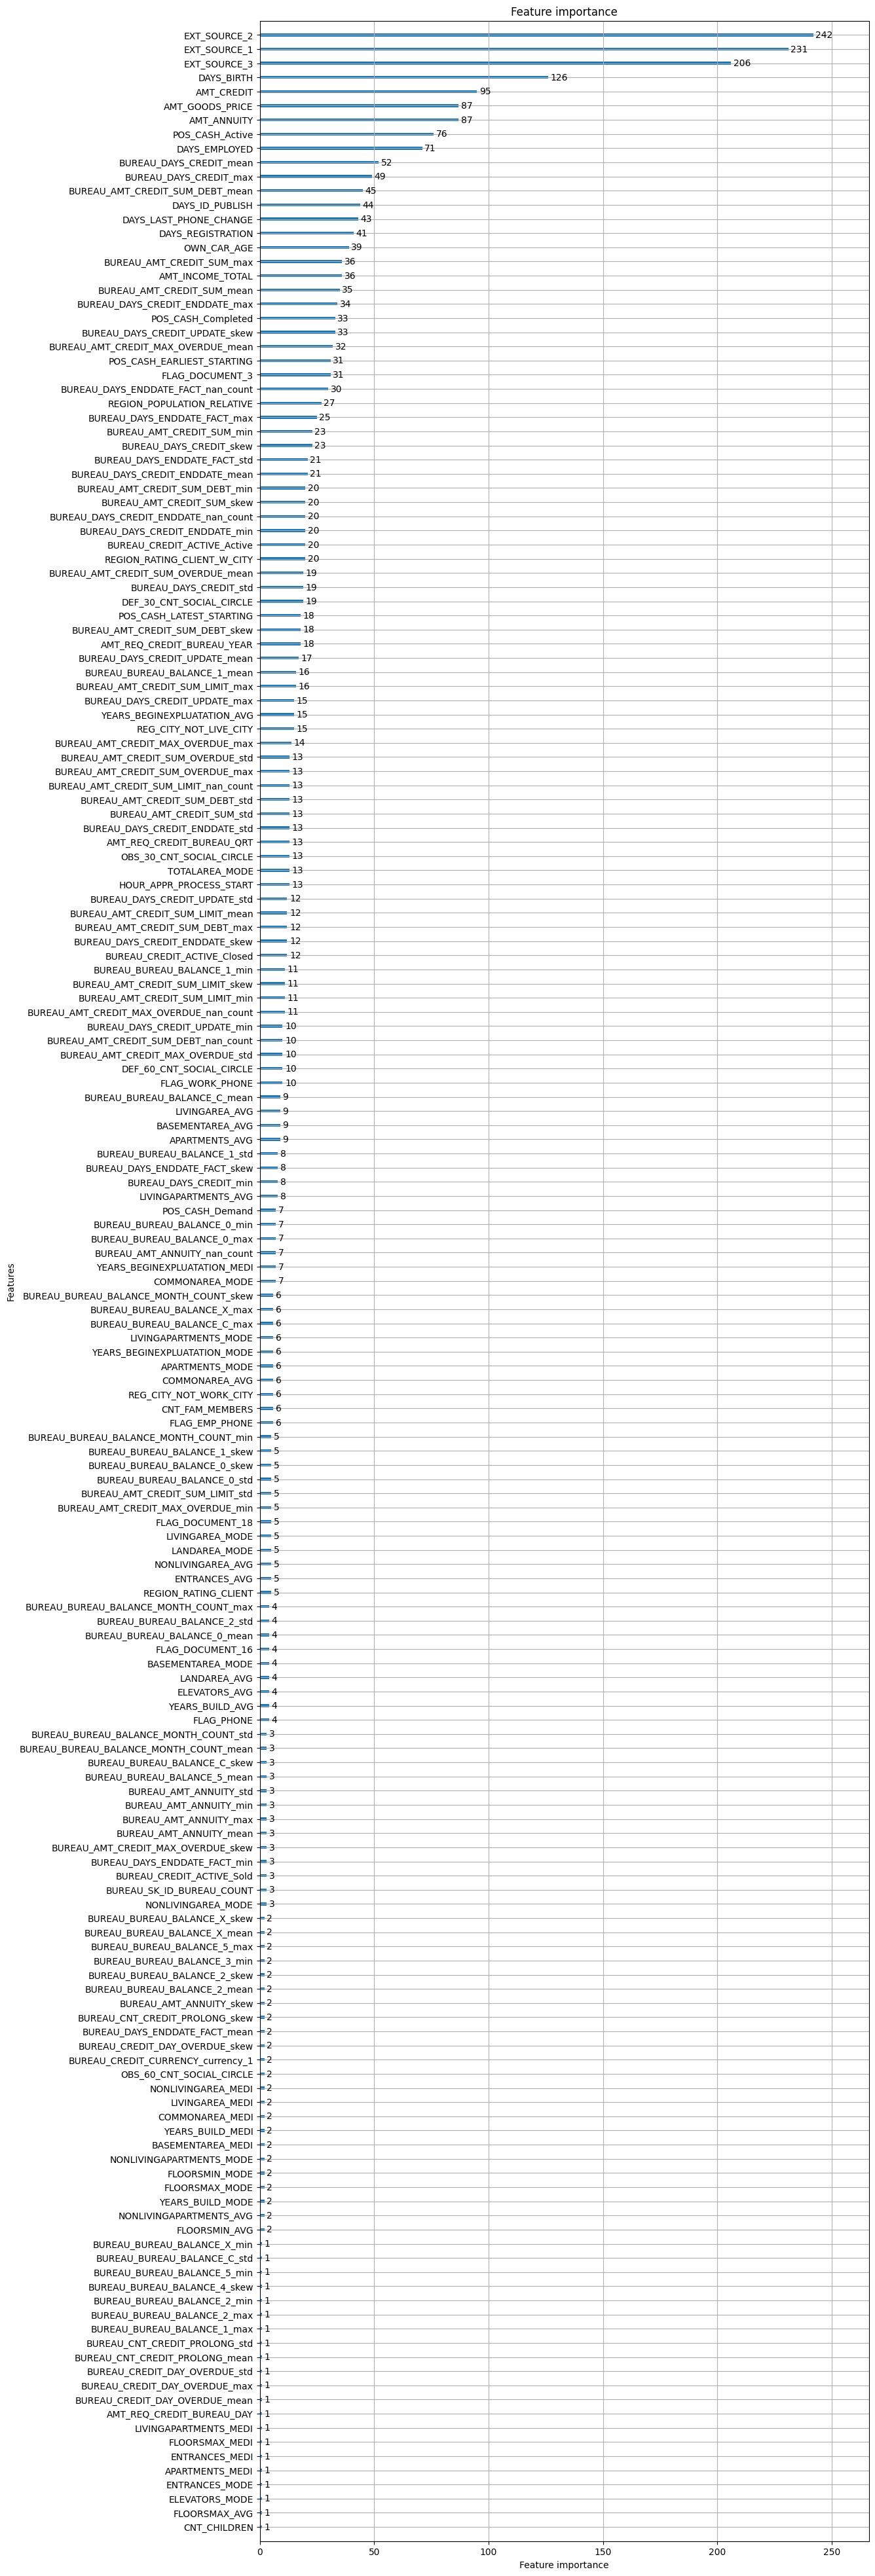

In [199]:
# plot feature importance
lgb.plot_importance(gbm, figsize=(12, 50))


In [200]:
home_credit_columns_description.where(home_credit_columns_description['Row'] == 'EXT_SOURCE_2').dropna(axis=0, how='all')['Description']

45    Normalized score from external data source
Name: Description, dtype: object